# Bike Sharing Demand EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

# Load Data

In [2]:
# parse_dates는 해당 column의 type을 datetime으로 만들어 줌
df_train = pd.read_csv('train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('test.csv', parse_dates=['datetime'])
df_submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])

In [3]:
df_train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields  
datetime - hourly date + timestamp   
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
holiday - whether the day is considered a holiday  
workingday - whether the day is neither a weekend nor holiday  
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy   
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist   
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
temp - temperature in Celsius  
atemp - "feels like" temperature in Celsius  
humidity - relative humidity  
windspeed - wind speed  
casual - number of non-registered user rentals initiated  
registered - number of registered user rentals initiated  
count - number of total rentals  

* 주의: season 1~4까지 봄, 여름, 가을, 겨울로 되어있지만 실제 데이터를 보면 1~3월을 봄으로 구분해놓았음. 따라서 봄, 여름, 가을, 겨울보다는 1분기, 2분기, 3분기, 4분기로 구분하는 게 올바름

In [4]:
df_test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [5]:
df_submission.head(3)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0


In [6]:
print(df_train.shape, df_test.shape)
print("훈련 데이터")
print(df_train.dtypes)
print("테스트 데이터")
print(df_test.dtypes)

(10886, 12) (6493, 9)
훈련 데이터
datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object
테스트 데이터
datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object


# Preliminary Wrangling

## 중복 체크
훈련 데이터, 테스트 데이터에 중복 값이 없음

In [7]:
sum(df_train.duplicated()), sum(df_test.duplicated())

(0, 0)

## Null 체크
훈련 데이터, 테스트 데이터에 null 값이 없음

In [8]:
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
df_test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## datetime을 세부적으로 나누기
datetime에서 년, 월, 일, 시간, 분, 초를 추출하여 각각 column으로 만들어 주기

In [10]:
df_train['year'] = df_train['datetime'].dt.year
df_train['month'] = df_train['datetime'].dt.month
df_train['day'] = df_train['datetime'].dt.day
df_train['hour'] = df_train['datetime'].dt.hour
df_train['minute'] = df_train['datetime'].dt.minute
df_train['second'] = df_train['datetime'].dt.second

In [11]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


# Visualization

## 년, 월, 일, 시간, 분, 초에 따른 대여량 평균치

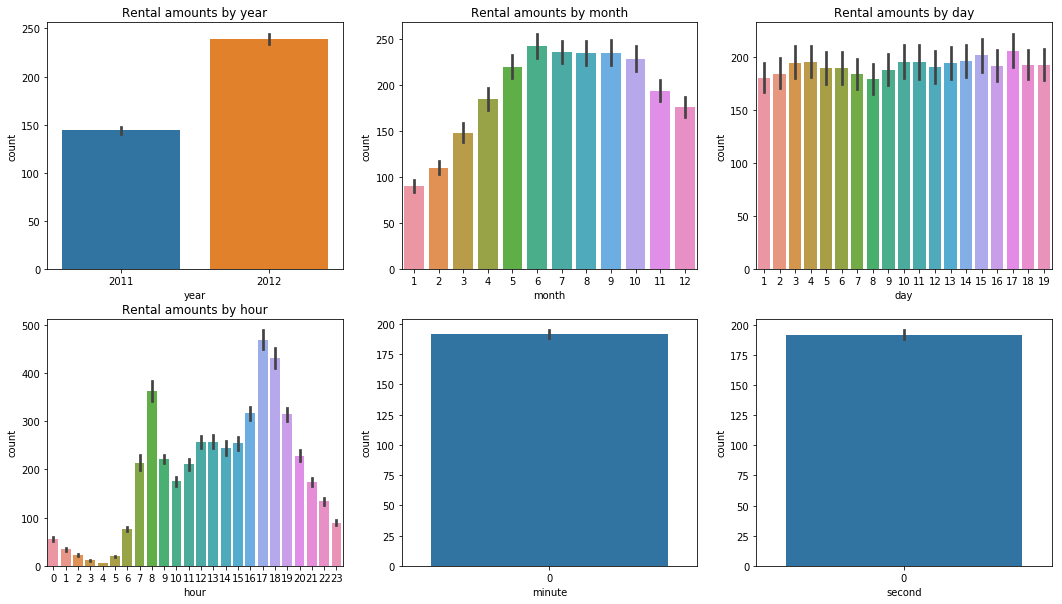

In [12]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 10)

sns.barplot(data=df_train, x="year", y="count", ax=ax1)
sns.barplot(data=df_train, x="month", y="count", ax=ax2)
sns.barplot(data=df_train, x="day", y="count", ax=ax3)
sns.barplot(data=df_train, x="hour", y="count", ax=ax4)
sns.barplot(data=df_train, x="minute", y="count", ax=ax5)
sns.barplot(data=df_train, x="second", y="count", ax=ax6)

ax1.set(title="Rental amounts by year")
ax2.set(title="Rental amounts by month")
ax3.set(title="Rental amounts by day")
ax4.set(title="Rental amounts by hour");

* 연별) 2011년보다 2012년 대여량이 많아짐
* 월별) 월별 대여량은 6월이 가장 많고, 주로 따뜻한 계절(5월~10월)에 대여량이 많음
* 일별) 일별 대여량에는 뚜렷한 차이가 없음, 그리고 train data에는 1~19일만 있고, test data에 20일~월말까지 있으므로 day를 feature로 사용할 수 없음
* 시간별) 출퇴근 시간인 8시, 17~18시에 대여량이 가장 많음
* 분, 초별) 분과 초는 모두 0으로 되어있어서 활용할 수 없음

## 시즌별, 시간별, 근무일/휴무일에 따른 대여량 평균치

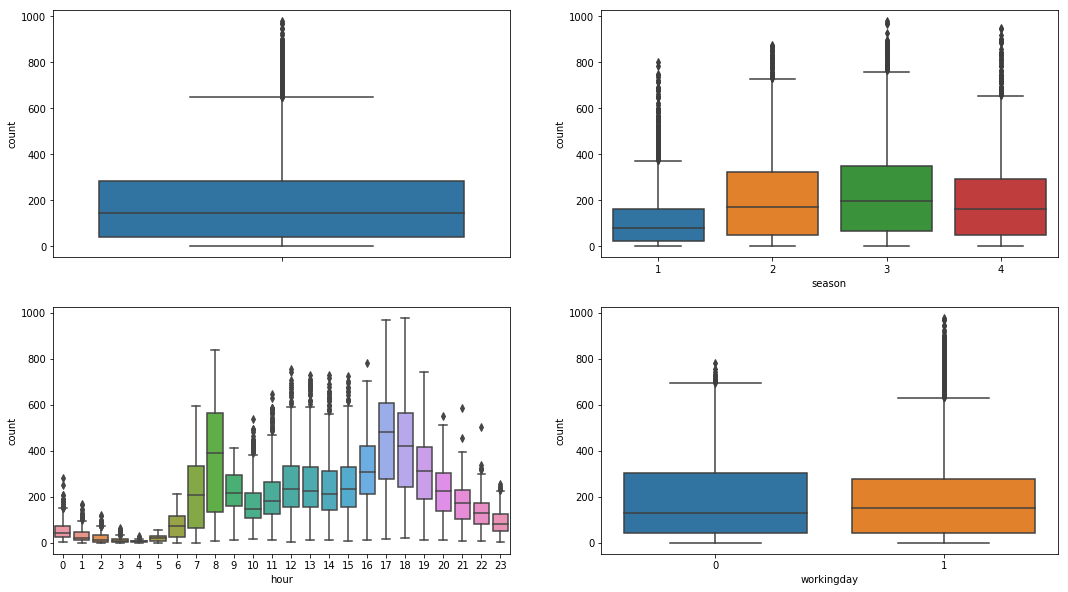

In [13]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18, 10)

sns.boxplot(data=df_train, y='count', ax=ax1)
sns.boxplot(data=df_train, x='season', y='count', ax=ax2)
sns.boxplot(data=df_train, x='hour', y='count', ax=ax3)
sns.boxplot(data=df_train, x='workingday', y='count', ax=ax4)


* season1~4가 봄, 여름, 가을, 겨울이 아니라 1~3월, 4~6월, 7~9월, 10~12월임. 따라서 봄, 여름, 가을, 겨울보다는 1사분기, 2사분기, 3사분기, 4사부기로 보는 게 맞음. season별로는 3사분기에 가장 많은 대여량을 기록함. 
* 시간대별로는 위에서 봤던 것처럼 출퇴근 시간이 가장 많음. 

## datetime을 기반으로 요일 추출

In [14]:
# The day of week with Monday=0, Sunday=6
df_train['dayofweek'] = df_train['datetime'].dt.dayofweek
df_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5


In [15]:
df_train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

* 당연한 말이지만 월,화,수,목,금,토,일 거의 비슷하게 분포되어 있음

## 시간대별 자전거 대여량 (by 근무일 유무, 요일, 시즌, 날씨)

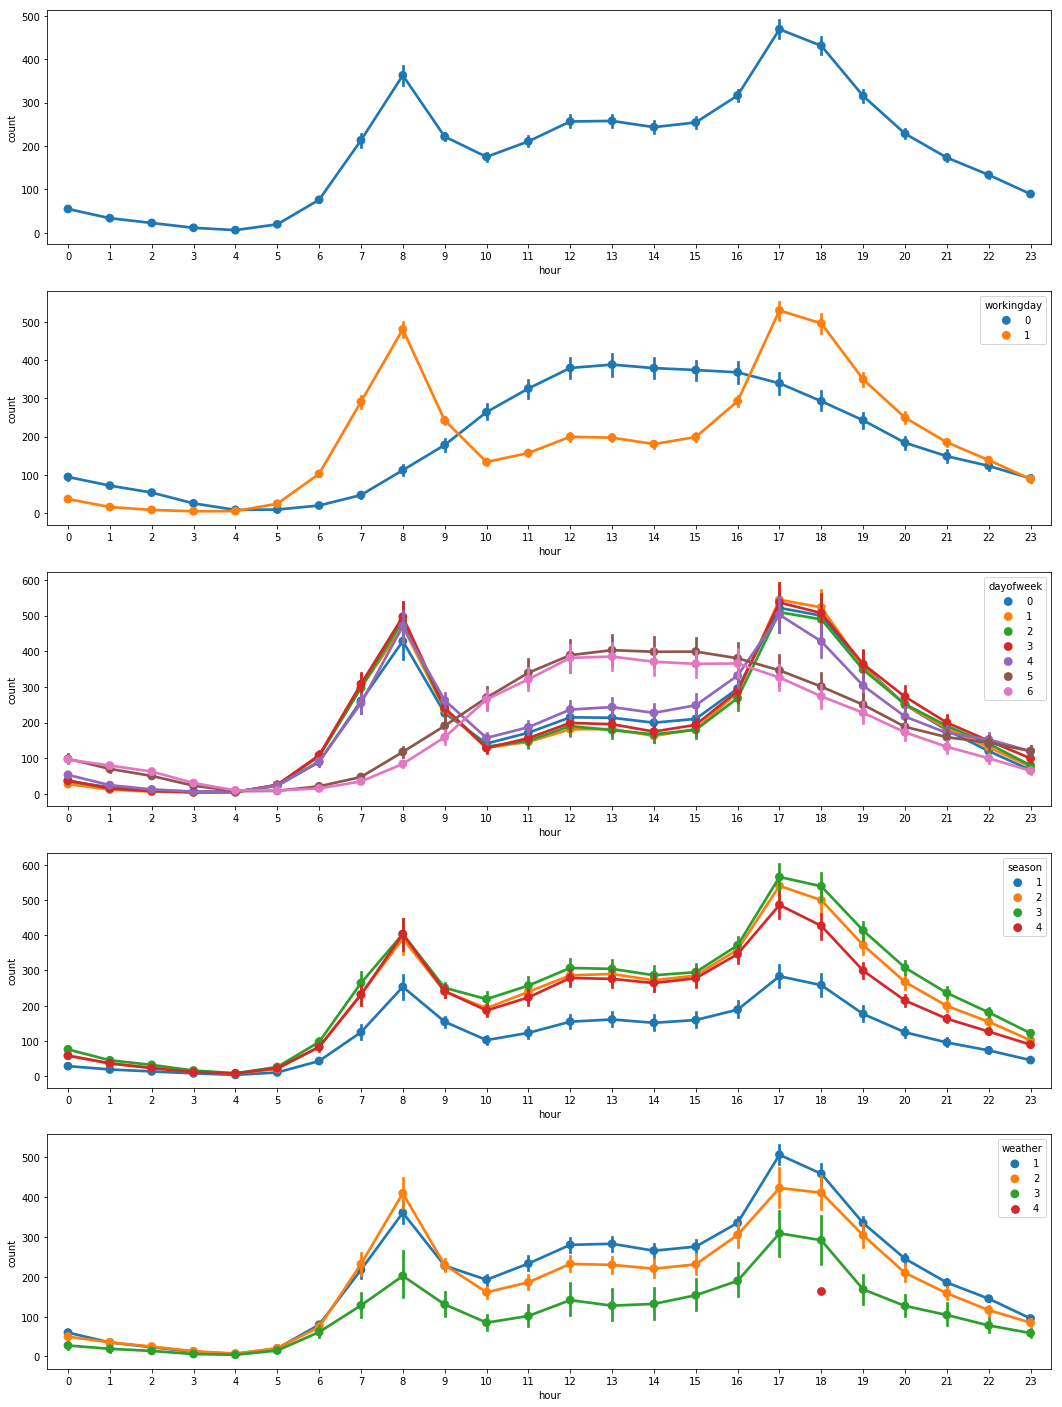

In [16]:
fig,(ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=df_train, x='hour', y='count', ax=ax1)
sns.pointplot(data=df_train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=df_train, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=df_train, x='hour', y='count', hue='season', ax=ax4)
sns.pointplot(data=df_train, x='hour', y='count', hue='weather', ax=ax5);

* 전체적으로 볼 때 출퇴근 시간에 자전거 대여량이 많음
* 근무일과 휴무일로 나누어보면 근무일에는 출퇴근 시간에 대여랑이 많고, 휴무일에는 낮시간에 대여량이 많음
* 요일로 나누어보면 월~금은 출퇴근 시간에 대여량이 많고, 토,일은 낮시간에 대여량이 많음
* 시즌별로 보면 1~3월에 대여량이 가장 적고, 7~9월에 대여량이 가장 많음
* 날씨별로 보면 날씨가 좋을 수록 대여량이 많고, 비가 많이 올 때는 대여량의 거의 없음

## faeture간 상관관계

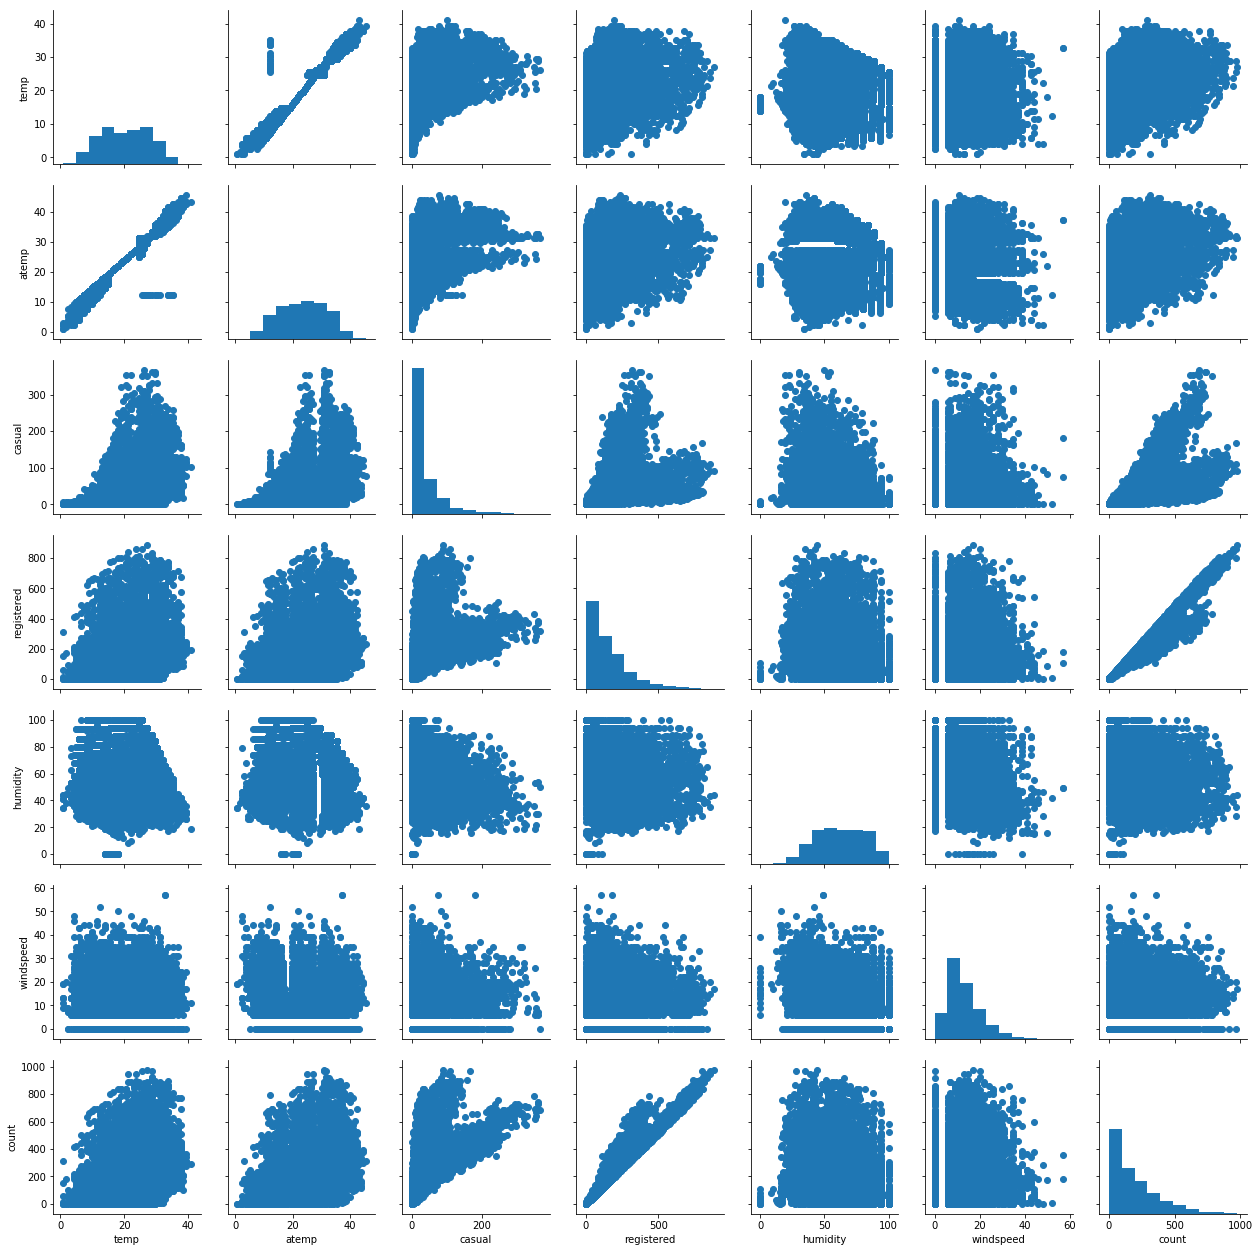

In [17]:
g = sns.PairGrid(data=df_train, vars=['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

In [18]:
corr_matrix = df_train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']]
corr_matrix = corr_matrix.corr()
corr_matrix

,temp,atemp,casual,registered,humidity,windspeed,count
temp,1.000000,0.984948,0.467097,0.318571,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,0.462067,0.314635,-0.043536,-0.057473,0.389784
casual,0.467097,0.462067,1.000000,0.497250,-0.348187,0.092276,0.690414
registered,0.318571,0.314635,0.497250,1.000000,-0.265458,0.091052,0.970948
humidity,-0.064949,-0.043536,-0.348187,-0.265458,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,0.092276,0.091052,-0.318607,1.000000,0.101369
count,0.394454,0.389784,0.690414,0.970948,-0.317371,0.101369,1.000000


In [19]:
mask = np.array(corr_matrix)
print(mask)
print(np.tril_indices_from(mask))
mask[np.tril_indices_from(mask)] = False
mask

[[ 1.          0.98494811  0.46709706  0.31857128 -0.06494877 -0.01785201
   0.39445364]
 [ 0.98494811  1.          0.46206654  0.31463539 -0.04353571 -0.057473
   0.38978444]
 [ 0.46709706  0.46206654  1.          0.49724969 -0.3481869   0.09227619
   0.69041357]
 [ 0.31857128  0.31463539  0.49724969  1.         -0.26545787  0.09105166
   0.97094811]
 [-0.06494877 -0.04353571 -0.3481869  -0.26545787  1.         -0.31860699
  -0.31737148]
 [-0.01785201 -0.057473    0.09227619  0.09105166 -0.31860699  1.
   0.10136947]
 [ 0.39445364  0.38978444  0.69041357  0.97094811 -0.31737148  0.10136947
   1.        ]]
(array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6], dtype=int64), array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 0,
       1, 2, 3, 4, 5, 6], dtype=int64))


array([[ 0.        ,  0.98494811,  0.46709706,  0.31857128, -0.06494877,
        -0.01785201,  0.39445364],
       [ 0.        ,  0.        ,  0.46206654,  0.31463539, -0.04353571,
        -0.057473  ,  0.38978444],
       [ 0.        ,  0.        ,  0.        ,  0.49724969, -0.3481869 ,
         0.09227619,  0.69041357],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.26545787,
         0.09105166,  0.97094811],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.31860699, -0.31737148],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.10136947],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

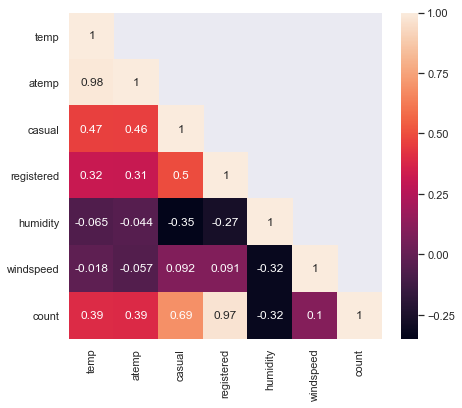

In [20]:
sns.set(rc={'figure.figsize':(7,6)})
sns.heatmap(corr_matrix, mask=mask, annot=True);

* 온도, 습도, 풍속은 상관관계가 거의 없음
* 대여량과 가장 상관관계가 높은 것은 registered지만 테스트 데이터에는 없으므로 사용할 수 없음
* 온도와 체감온도는 당연히 상관관계가 높지만 큰 의미가 있지는 않음

## 기온, 풍속, 습도 시각화

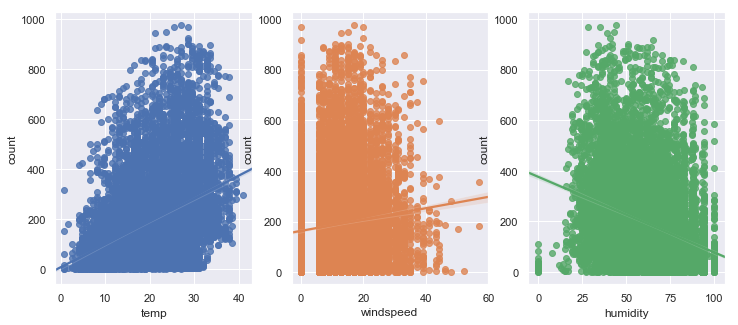

In [21]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=df_train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=df_train,ax=ax2)
sns.regplot(x="humidity", y="count", data=df_train,ax=ax3);

* 풍속이 0인 데이터가 많은 것은 관측치가 없기 때문인 것으로 사료됨

## 연도별, 월별 자전거 대여량

In [22]:
def concat_year_month(datetime):
    return '{0}-{1}'.format(datetime.year, datetime.month)

df_train['year_month'] = df_train['datetime'].apply(concat_year_month)

df_train[['datetime', 'year_month']].head()

,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


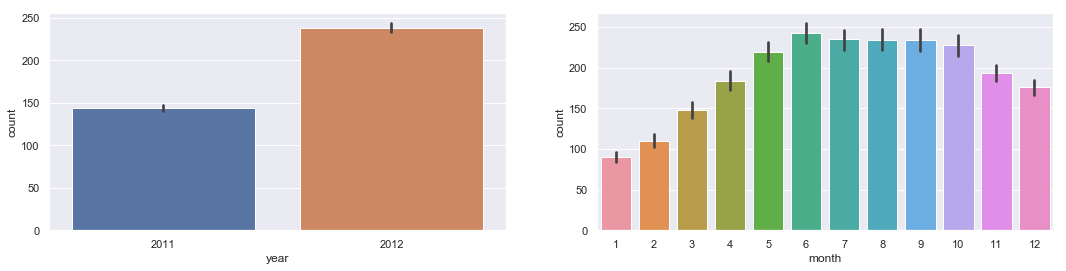

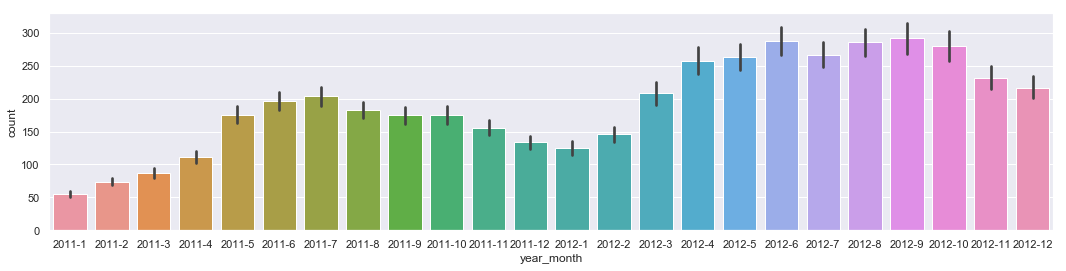

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)
sns.barplot(data=df_train, x='year', y='count', ax=ax1)
sns.barplot(data=df_train, x='month', y='count', ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)
sns.barplot(data=df_train, x='year_month', y='count', ax=ax3);

* 2011년보다 2012년의 대여량이 더 많음
* 주로 여름철 대여량이 많고, 그중 6월이 가장 많음
* 2011년과 2012년의 월별 대여량 양상은 비슷하나 2012년에 대여량이 더 많음

## 3시그마 초과하는 아웃라이어 제거[](http://)

In [24]:
df_train_without_outliers = df_train[df_train['count'] - df_train['count'].mean() < 3*df_train['count'].std()]

print(df_train.shape)
print(df_train_without_outliers.shape)

(10886, 20)
(10739, 20)


## 대여량 로그화

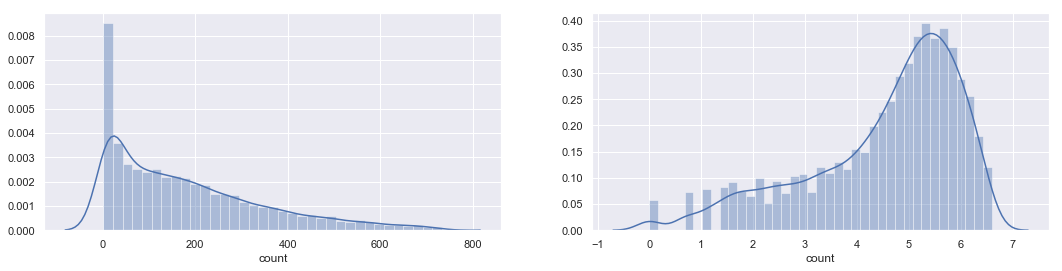

In [25]:
figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,4)

sns.distplot(df_train_without_outliers['count'], ax=axes[0]);
sns.distplot(np.log(df_train_without_outliers['count']), ax=axes[1]);

종속 변수가 정규분포를 따르면 분석이 용이함, 따라서 로그화를 취해주었음, 완벽한 정규분포는 아니지만 보다 정규분포에 가까워짐